## Driver drowsiness detection

###  Importing labraries

In [32]:
import numpy as np 
import pandas as pd 
import os
import cv2
import keras
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


## Data preprocessing

In [2]:
labels = os.listdir("./drowsiness-dataset/train")

In [3]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

visualize random image

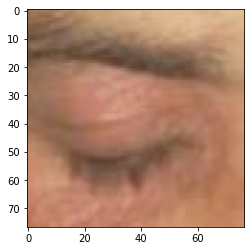

In [50]:
plt.imshow(plt.imread("./drowsiness-dataset/train/Closed/_40.jpg"))

In [5]:
a = plt.imread("./drowsiness-dataset/train/yawn/15.jpg")

In [6]:
a.shape

(480, 640, 3)

 visualize yawn image. 

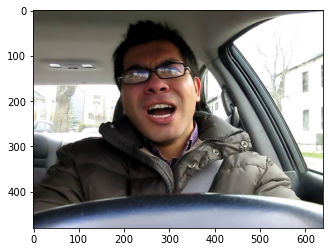

In [46]:
plt.imshow(plt.imread("./drowsiness-dataset/train/yawn/30.jpg"))

background is not necessary .So we focus only on the face 

In [8]:
def face_for_yawn(direc="./drowsiness-dataset/train", face_cas_path="./haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [9]:
def get_data(dir_path="./drowsiness-dataset/train/", face_cas="./haarcascade_frontalface_default.xml", eye_cas="./haarcascade_eye.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [10]:
data_train = get_data()

2
3


extend data and convert array

In [11]:
def append_data():

    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [12]:
new_data = append_data()

0
1
2
3


C:\Users\ALAATR~1\AppData\Local\Temp/ipykernel_17468/2804427426.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(yaw_no)


separate label and features

In [13]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

 reshape the array

In [14]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

LabelBinarizer

In [15]:
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [16]:
y = np.array(y)

train/test split data

In [17]:
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [18]:
len(X_test)

577

### Data Augmentation

In [23]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [24]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 143, 143, 256)     7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 71, 71, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 69, 69, 128)       295040    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1

In [25]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 124s 3s/step - loss: 1.1629 - accuracy: 0.4777 - val_loss: 0.6237 - val_accuracy: 0.7782
Epoch 2/50
43/43 [==============================] - 124s 3s/step - loss: 0.5433 - accuracy: 0.7727 - val_loss: 0.4843 - val_accuracy: 0.7868
Epoch 3/50
43/43 [==============================] - 122s 3s/step - loss: 0.4360 - accuracy: 0.8068 - val_loss: 0.3240 - val_accuracy: 0.8821
Epoch 4/50
43/43 [==============================] - 123s 3s/step - loss: 0.3437 - accuracy: 0.8536 - val_loss: 0.3265 - val_accuracy: 0.8718
Epoch 5/50
43/43 [==============================] - 122s 3s/step - loss: 0.3417 - accuracy: 0.8574 - val_loss: 0.2510 - val_accuracy: 0.9012
Epoch 6/50
43/43 [==============================] - 122s 3s/step - loss: 0.2822 - accuracy: 0.8893 - val_loss: 0.2773 - val_accuracy: 0.8995
Epoch 7/50
43/43 [==============================] - 127s 3s/step - loss: 0.2761 - accuracy: 0.8819 - val_loss: 0.2560 - val_accuracy: 0.9029
Epoch 8/50
43

# plotting history

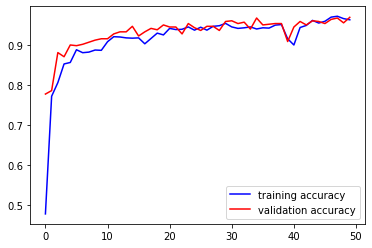

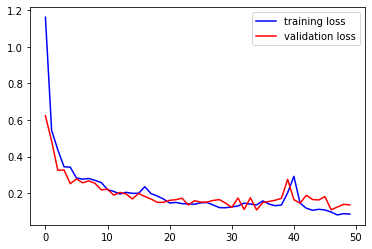

In [47]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="training accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="training loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

# save model

In [48]:
model.save("drowiness_x.h5")

In [49]:
model.save("drowiness_x.model")

INFO:tensorflow:Assets written to: drowiness_x.model\assets


# Prediction

In [33]:
prediction = model.predict(X_test)

In [34]:
prediction

array([[4.8506137e-13, 1.0918013e-18, 9.0862358e-01, 9.1376401e-02],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [2.6448860e-18, 8.7440360e-25, 1.0000000e+00, 9.7470166e-17],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],
      dtype=float32)

In [35]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

# predict function

In [37]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="./haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_x.h5")

# Test our model 
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [39]:
prediction = model.predict([prepare("./drowsiness-dataset/train/no_yawn/1067.jpg")])
np.argmax(prediction)

1

In [44]:
prediction = model.predict([prepare("./drowsiness-dataset/train/Closed/_107.jpg")])
np.argmax(prediction)

2